Testing CNN method from https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy#:~:text=%EF%BB%BFKeras%20is%20a%20go,both%20beginners%20and%20advanced%20users.

https://keras.io/guides/sequential_model/

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers # example functions: Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from keras import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
%run FeedingData.ipynb
# read Calvin's function files so we can call those functions from this notebook
# list of functions: 
# mfcc_(song, n=20)
# mfcc_cut(song, n=20, cutoff = 800)
# LFCC(song, n=20)
# LFCC_no_low(song, n=20, cutoff = 800)
# LFCC_no_low_clean(song, n=20, cutoff = 800)
# mfcc_cut_cleaned(song, n=20, cutoff = 800)
# main_freq(song, cutoff = 800)

In [5]:
def get_hs_avg_var_mfccs(song, sr, n = 40, cutoff = 800):
    max_ampj = np.argmax(abs(song))
    time_start, time_stop = round(max_ampj - sr/4), round(max_ampj + sr/4)
    if time_start < 0:
        time_start, time_stop = 0, round(sr/2)
    if time_stop > len(song):
        time_start, time_stop = len(song) - round(sr/2), len(song)
    mfccs = librosa.feature.mfcc(y = song[time_start:time_stop], fmin = cutoff, n_mfcc = n)
    mfcc_avg = np.mean(mfccs, axis = 1)
    mfcc_var = np.var(mfccs, axis = 1)
    if time_start < 0: return (np.full(20, np.nan), np.full(20, np.nan))
    else: 
        return (mfcc_avg, mfcc_var)

In [3]:
def get_vec_data(audio_path, meta_file, load_length):
    songs_matrix = []
    songs_id = []
    df = pd.read_csv(meta_file)
    id_list = df.cat_num

    for name in id_list:
        filepath = os.path.join(audio_path, str(name)+'.wav')
        # skipping files that are less than 250 ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < load_length*50000:
            continue
        # ============ load the data and get matrix ============
        # make sure that the size of the feature matrix is the same for all files
        song, sr = librosa.load(filepath, duration=load_length)
        mean, var = get_hs_avg_var_mfccs(song, sr)
        long_vec = np.concatenate((mean, var))
        songs_matrix.append(long_vec)
        songs_id.append(name)
    return np.array(songs_matrix), songs_id

In [4]:
def get_data(audio_path, meta_file, load_length, get_feature_function):
    songs_matrix = []
    songs_id = []
    df = pd.read_csv(meta_file)
    id_list = df.cat_num

    for name in id_list:
        filepath = os.path.join(audio_path, str(name)+'.wav')
        # skipping files that are less than 250 ~ 5sec long
        # this is to make sure we have enough length for sampling fft time intervals
        if os.path.getsize(filepath) < load_length*50000:
            continue
        # ============ load the data and get matrix ============
        # make sure that the size of the feature matrix is the same for all files
        song, sr = librosa.load(filepath, duration=load_length)
        features = get_feature_function(song, n = 40)
        songs_matrix.append(features)
        songs_id.append(name)
    return np.array(songs_matrix), songs_id

In [6]:
def get_labels(numbers, meta_file, label_name):
    # take in list of data id numbers and output their labels in label_name calssification
    df = pd.read_csv(meta_file)
    labels = []
    for num in numbers:
        labels.append(df[label_name].loc[df.cat_num == float(num)].item())
    return np.array(labels)

In [7]:
# for converting strings of label from one division to another, e.g. fam/subfam to critter name
def convert_labels(labels, meta_file, from_division, to_division):
    # find label in labels in meta_file under column from_division
    # append as key in dictionary lookup_table, append as value the corresponding label in to_division

    df = pd.read_csv(meta_file, usecols=[from_division, to_division])
    lookup_table = dict() # look up table for new label
    for label in labels:
        if label in lookup_table.keys():
            continue
        idx = df.loc[df[from_division]==label].index[0]
        lookup_table[label] = df[to_division][idx]
    return [lookup_table[label] for label in labels]

In [8]:
def remove_small_class(songs_matrix, songs_label, threshold):
    df_class = pd.DataFrame(np.unique(songs_label, return_counts=True)).T
    print('Data read:\n', df_class)
    # remove classes with too few data points
    small_class_list = []
    for row in range(len(df_class)):
        if df_class[1].iloc[row] < threshold:
            small_class_list.append(df_class[0].iloc[row].item())
    print('Removing classes:\n',small_class_list)
    delete_list = []
    for small_class in small_class_list:
        delete_list += list(np.where(songs_label==small_class)[0])

    short_label = np.delete(songs_label, delete_list)
    short_matrix = np.delete(songs_matrix, delete_list, 0)
    # double check data after deleting
    print('Reduced data:\n', pd.DataFrame(np.unique(short_label, return_counts=True)).T)
    return short_matrix, short_label

In [50]:
def plot_history(history):
    history_dict = history.history
    epochs=len(list(history_dict.values())[0])
    plt.figure(figsize = (4, 3))
    plt.scatter(range(1,epochs+1), history_dict['accuracy'], label = "Training Accuracy")
    plt.scatter(range(1,epochs+1), history_dict['val_accuracy'], label = "Validation Set Accuracy")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12)
    plt.show()

    plt.figure(figsize = (4, 3))
    plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
    plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss Function Value", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12)
    plt.show()

In [104]:
def plot_confusion(true_class, pred_class):
    #labels = (np.unique(true_class))
    labels = ('cicada', 'cricket', 'katydid')
    conf_mat = confusion_matrix(true_class, pred_class)#, labels=labels)
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
    disp.plot(xticks_rotation='vertical')
    fig = disp.figure_
    fig.set_figwidth(3)
    fig.set_figheight(3) 
    plt.show()
    accuracy = np.diagonal(conf_mat).sum()/np.sum(conf_mat)
    print('accuracy =', accuracy)

### Use this if there's no saved data file

In [ ]:
# load all audio in audio_path
# convert to matrix, save in np array, 
# load the corresponding label_name from lable_filename, save in another np array

audio_path = 'E:\chirpfiles\\no_voice_files'
meta_file = 'MLNS_Final_Train.csv'

start = time.time()
max_time = 5 # cut off time for loading, in sec
get_feature_function = mfcc_cut_cleaned
songs_matrix, songs_id = get_data(audio_path, meta_file, max_time, get_feature_function)
songs_label_critter = get_labels(songs_id, meta_file, 'critter_name')
songs_label_fam = get_labels(songs_id, meta_file, 'fam_or_subfam')
end = time.time()
print('time loading:', end - start)

### Save if loaded new data files

In [ ]:
np.save('E:\chirpfiles\\songs_matrix_mfcc_cut_cleaned_5sec.npy', songs_matrix)
np.save('E:\chirpfiles\\songs_label_critter_5sec.npy', songs_label_critter)
np.save('E:\chirpfiles\\songs_label_fam_5sec.npy', songs_label_fam)
np.save('E:\chirpfiles\\songs_id_5sec.npy', songs_id)

### Use this if there are saved data files

In [11]:
songs_matrix = np.load('E:\chirpfiles\\songs_matrix_mfcc_cut_cleaned_5sec.npy')
songs_label_critter = np.load('E:\chirpfiles\\songs_label_critter_5sec.npy')
songs_label_fam = np.load('E:\chirpfiles\\songs_label_fam_5sec.npy')
songs_id = np.load('E:\chirpfiles\\songs_id_5sec.npy')

### If want to drop smaller classes for more balanced dataset

In [ ]:
short_matrix, short_label = remove_small_class(songs_matrix, songs_label_fam, 11)

In [93]:
# convert insec fam into numbers. use le.inverse_transform to go from number to name
le = LabelEncoder()
songs_label_num = le.fit_transform(songs_label_fam)
songs_label_onehot = to_categorical(songs_label_num) # required output format by cnn

# rename data/label variable name so that we don't need to change them in the model block
data_matrix = songs_matrix
data_label = songs_label_onehot

# after 5/30, we are using already splitted data so this is already train and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_matrix, data_label, stratify=songs_label_num,
                                                  test_size = .2, random_state = 17)
# to use 2d convolution, keras model expects 4d input shape
#X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
#X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
#print('Train test split train shape: ', X_train.shape)

#X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 17)
#print('Train validation split train shape: ', X_tt.shape)

In [94]:
# make model 
input_shape =  (X_train.shape[1], X_train.shape[2],1,) # first dimension of train data is n_datapoints
model = Sequential([
    Input(input_shape),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    #layers.Dense(64, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(len(le.classes_), activation='softmax')
]) 

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [95]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 40, 216, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 20, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 20, 108, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 20, 108, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 10, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 10, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 34560)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 15)                  │         518,415 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,231 (2.05 MB)

 Trainable params: 537,231 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
# train model
start = time.time()
epochs = 50
early_stopping = EarlyStopping(monitor='val_loss', patience=4)
checkpoint_filepath = 'E:/chirpfiles/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, model_checkpoint_callback])
end = time.time()
print('time training: ', end - start)
model.load_weights(checkpoint_filepath)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 318ms/step - accuracy: 0.1957 - loss: 8.0638 - val_accuracy: 0.4208 - val_loss: 2.1705
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 310ms/step - accuracy: 0.4212 - loss: 1.8269 - val_accuracy: 0.4551 - val_loss: 1.6056
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.5257 - loss: 1.4354 - val_accuracy: 0.5172 - val_loss: 1.4832
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 308ms/step - accuracy: 0.5879 - loss: 1.2301 - val_accuracy: 0.5393 - val_loss: 1.4204
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step - accuracy: 0.6625 - loss: 1.0290 - val_accuracy: 0.5537 - val_loss: 1.3397
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step - accuracy: 0.7279 - loss: 0.8177 - val_accuracy: 0.5703 - val_loss: 1.3681
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 309ms/step - accuracy: 0.7793 - loss: 0.6450 - val_accuracy: 0.5759 - val_loss: 1.3977
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.8272 - loss: 0.5348 - val_accu

### Save training history, just the accuracy and lost at each epoch

In [55]:
with open('E:\chirpfiles\hist_mfcc_c_c_twohiddenlayer_64_128_5sec_fam.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(history, f)

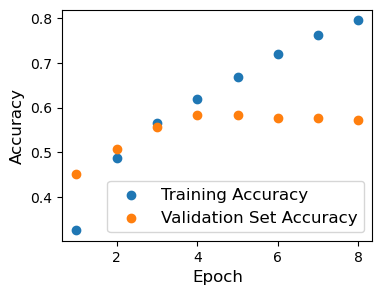

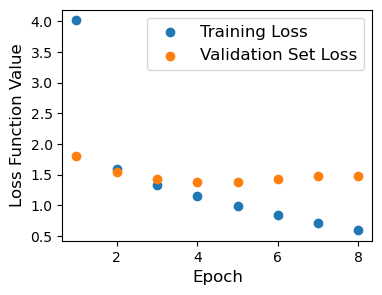

In [69]:
plot_history(history)

# vvv
### Report accuracy on validation set 

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


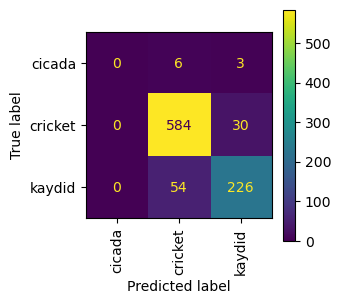

accuracy = 0.8970099667774086


In [82]:

predicted_vector = model.predict(X_val)
predicted_class_index = np.argmax(predicted_vector, axis=-1)
pred_class = le.inverse_transform(predicted_class_index)
true_class_idx = np.where(y_val.astype(int))[1]
true_class = le.inverse_transform(true_class_idx)
plot_confusion(true_class, pred_class)

#### If used family classfication above, can reduce to critter name classfication below

In [ ]:
print(np.unique(true_class))

## to shorte list of classes after fitting on long list, use the class converter. 
label_name = 'fam_or_subfam'
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')
plot_confusion(true_class_short, pred_class_short)

# vvv 
## Forbidden test set block

### load and transform data from test file, predict and plot confusion matrix

In [ ]:
audio_path = 'E:\chirpfiles\\no_voice_files'
meta_file = 'MLNS_Final_Test.csv'

max_time = 5 # cut off time for loading, in sec
get_feature_function = mfcc_cut_cleaned
test_songs_matrix, test_songs_id = get_data(audio_path, meta_file, max_time, get_feature_function)
test_songs_label_critter = get_labels(test_songs_id, meta_file, 'critter_name')
test_songs_label_fam = get_labels(test_songs_id, meta_file, 'fam_or_subfam')


#### Save new data

In [ ]:
np.save('E:\chirpfiles\\test_songs_matrix_mfcc_cut_cleaned_5sec.npy', test_songs_matrix)
np.save('E:\chirpfiles\\test_songs_label_critter_5sec.npy', test_songs_label_critter)
np.save('E:\chirpfiles\\test_songs_label_fam_5sec.npy', test_songs_label_fam)
np.save('E:\chirpfiles\\test_songs_id_5sec.npy', test_songs_id)

#### Load existing data

In [57]:
test_songs_matrix=np.load('E:\chirpfiles\\test_songs_matrix_mfcc_cut_cleaned_5sec.npy')
test_songs_label_critter=np.load('E:\chirpfiles\\test_songs_label_critter_5sec.npy')
test_songs_label_fam=np.load('E:\chirpfiles\\test_songs_label_fam_5sec.npy')
test_songs_id=np.load('E:\chirpfiles\\test_songs_id_5sec.npy')

In [ ]:
short_matrix, short_label = remove_small_class(test_songs_matrix, test_songs_label_critter, 3)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


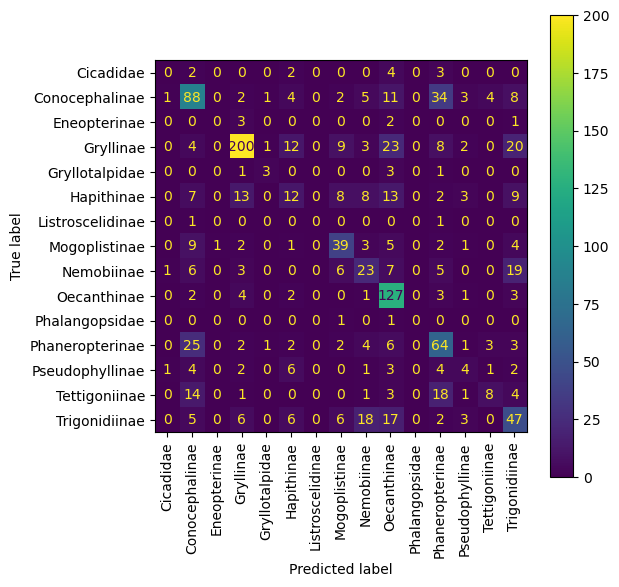

accuracy = 0.5442477876106194


In [102]:
predicted_vector = model.predict(test_songs_matrix)
predicted_class_index = np.argmax(predicted_vector, axis=-1)

pred_class = le.inverse_transform(predicted_class_index)

#true_class_idx = np.where(test_songs_label_fam.astype(int))[1]
#true_class = le.inverse_transform(true_class_idx)
true_class = test_songs_label_fam
plot_confusion(true_class, pred_class)

### If used family classification above, can reduce to critter using block below

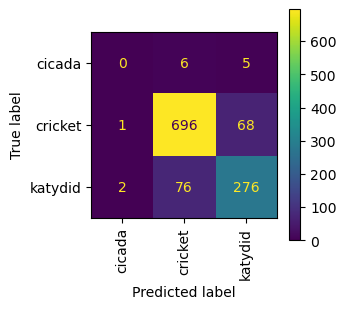

accuracy = 0.8601769911504424


In [105]:
label_name = 'fam_or_subfam'
meta_file = 'MLNS_Final_Test.csv'
## to shorte list of classes after fitting on long list, use the class converter. 
true_class_short = convert_labels(true_class, meta_file, label_name, 'critter_name')
pred_class_short = convert_labels(pred_class, meta_file, label_name, 'critter_name')

plot_confusion(true_class_short, pred_class_short)

### Save prediction and true labels

In [103]:
with open('E:\chirpfiles\\test_set_mfcc_c_c_twohiddenlayer_64_128_5sec_fam.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([true_class, pred_class], f)